# Direct Search
---

This notebook is used to perform an multi-objective robust optimization and analyze the results.
<!-- Table of Content -->
## Table of Content
- [1. Importing libraries](#1.-Importing-libraries)
- [2. Initialize Model](#2.-Defining-the-problem)
- [3. Defining the algorithm](#3.-Defining-the-algorithm)
- [4. Running the algorithm](#4.-Running-the-algorithm)
- [5. Plotting the results](#5.-Plotting-the-results)
- [6. Saving the results](#6.-Saving-the-results)
- [7. References](#7.-References)


---

## 1. Importing libraries

In [22]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# EMA
from ema_workbench import (  Scenario, MultiprocessingEvaluator, ScalarOutcome, ema_logging)
from ema_workbench import  Policy,Scenario
from ema_workbench import save_results, load_results
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.analysis import parcoords
# Model
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)
# parameters for improved visualization
plt.rcParams["figure.figsize"] = (10, 6)
sns.set_style("whitegrid")

## 2. Initialize Model
We import the model for the speicified problem formulation and define the reference scenario that should be used for the robust optimization. Moreover, we also set the number of functional evaluations to 50.000 as limited computer resources are available.

In [2]:
#------------------------- Set Model Parameters
problem_formulation = 6
model, steps = get_model_for_problem_formulation(problem_formulation)

uncertainties = model.uncertainties
levers = model.levers
outcomes = model.outcomes

#------------------------- Reference Scenario
ref_val = {'Bmax': 175, 
           'Brate': 1.5, 
           'pfail': 0.5,
            'discount rate': 3.5,
            'ID flood wave shape': 4}

ref_dict = {}
# < ref_dict >
# reference scenario updated for all dike rings
for key in model.uncertainties:
    name_split = key.name.split('_')
    if len(name_split) == 1:
        if key.name in ref_val.keys():
            ref_dict.update({key.name: ref_val[key.name]})
    else:
        ref_dict.update({key.name: ref_val[name_split[1]]})


#------------------------- Optimization Parameters

ref_scenario = Scenario('reference', **ref_dict)

convergence_metrics = [EpsilonProgress()]
#Set number of functional evaluations
nfe = 50000

### 2.1 Search for optimal Solutions
For the optimization we use a Multi-objective evolutionary algorithm (MOEA). We set to search over the levers of the model and use epsillon progress for the convergence metric.

In [4]:
'''

ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model, n_processes = 6) as evaluator:
    results, convergence = evaluator.optimize(nfe=nfe,
                                            searchover='levers',
                                            epsilons=[0.1]*len(model.outcomes),
                                              convergence=convergence_metrics,
                                            reference=ref_scenario
                                            )
#Save Results    
results.to_csv('results/optimization_{}_{}_noEWS.csv'.format(problem_formulation,nfe))

'''

"\n\nema_logging.log_to_stderr(ema_logging.INFO)\nwith MultiprocessingEvaluator(model, n_processes = 6) as evaluator:\n    results1, convergence = evaluator.optimize(nfe=nfe,\n                                            searchover='levers',\n                                            epsilons=[0.1]*len(model.outcomes),\n                                              convergence=convergence_metrics,\n                                            reference=ref_scenario\n                                            )\n    \nresults1.to_csv('results/optimization_{}_{}_noEWS.csv'.format(problem_formulation,nfe))\n\n"

In [11]:
# final result data set
results = pd.read_csv("results/optimization_6_50000_noEWS.csv")
#show max, min etc for all outcomes
results.describe()

,Unnamed: 0,0_RfR 0,1_RfR 0,2_RfR 0,3_RfR 0,4_RfR 0,EWS_DaysToThreat,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,...,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Dike Investment Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
count,7782.00000,7782.000000,7782.000000,7782.000000,7782.000000,7782.000000,7782.000000,7782.000000,7782.000000,7782.000000,...,7.782000e+03,7782.000000,7.782000e+03,7.782000e+03,7782.000000,7.782000e+03,7.782000e+03,7782.000000,7.782000e+03,7782.0
mean,3890.50000,0.346569,0.163454,0.523002,0.525829,0.258802,0.469417,2.130172,2.892830,2.499100,...,2.073423e+07,0.012266,2.999781e+06,6.516115e+06,0.000612,1.781842e+07,2.448978e+07,0.006371,2.109859e+08,0.0
std,2246.61423,0.475908,0.369803,0.499503,0.499365,0.438005,0.499096,1.905934,1.843254,1.878643,...,9.335026e+06,0.017379,4.274708e+06,3.775989e+06,0.000863,3.058257e+07,1.264701e+07,0.010931,1.794070e+08,0.0
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0
25%,1945.25000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,...,2.029929e+07,0.000000,0.000000e+00,6.320800e+06,0.000000,0.000000e+00,2.503721e+07,0.000000,8.460000e+07,0.0
50%,3890.50000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,3.000000,2.000000,...,2.216782e+07,0.002833,6.016331e+05,7.332080e+06,0.000132,0.000000e+00,2.757823e+07,0.000000,1.519000e+08,0.0
75%,5835.75000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,4.000000,4.000000,...,2.640338e+07,0.019780,4.244225e+06,8.453408e+06,0.000909,2.609170e+07,3.035153e+07,0.009225,3.697000e+08,0.0
max,7781.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,10.000000,10.000000,...,4.421502e+07,0.076905,1.557984e+07,2.038434e+07,0.003184,1.238835e+08,5.817663e+07,0.044445,7.104000e+08,0.0


In [126]:
convergence = pd.read_csv("results/convergence_6_50000_noEWS.csv")

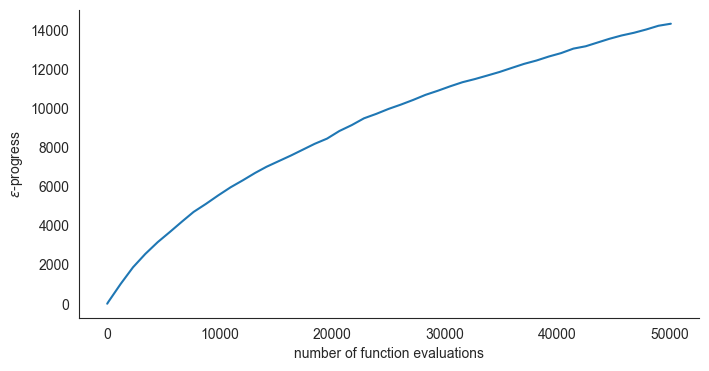

In [128]:
fig, (ax1) = plt.subplots(ncols=1, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
# Remove the top and right spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.set_xlabel('number of function evaluations')
plt.show()

The graph shows that with a higher number of nfes the relative gain in epsilon progress decreases. However, it is evident that 50.000 is not yet enough to fully stabilize the epsilon progress but due to limited resources we will have to use this number of nfes.

['Gelderland_Damages', 'Gelderland_Investment', 'Overijssel_Damages', 'Overijssel_Investment']


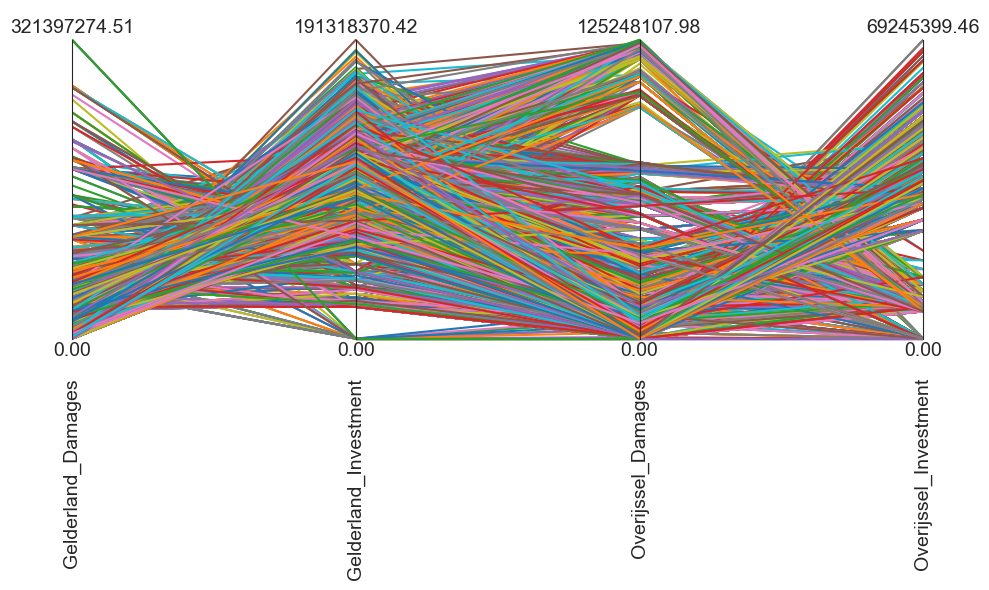

In [15]:
""" 
@Ryan
 """
#to_display = results.columns.tolist()
#excludeall EWS variables

to_display = [ 'Gelderland_Damages', 'Gelderland_Investment', 'Overijssel_Damages', 'Overijssel_Investment']
data = results.loc[:, to_display]
print(to_display)
limits = parcoords.get_limits(data)
limits.loc[0, to_display] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)


plt.show()


In [13]:
#Create aggregate columns for death, damage and investment cost
results["Gelderland_Deaths"] = results[[f"A.{i+1}_Expected Number of Deaths" for i in range(3)]].sum(axis=1)
results["Gelderland_Damages"] = results[[f"A.{i+1}_Expected Annual Damage" for i in range(3)]].sum(axis=1)
results["Gelderland_Investment"] = results[[f"A.{i+1}_Dike Investment Costs" for i in range(3)]].sum(axis=1)
results["Overijssel_Deaths"] = results[[f"A.{i}_Expected Number of Deaths" for i in [4, 5]]].sum(axis=1)
results["Overijssel_Damages"] = results[[f"A.{i}_Expected Annual Damage" for i in [4, 5]]].sum(axis=1)
results["Overijssel_Investment"] = results[[f"A.{i}_Dike Investment Costs" for i in [4, 5]]].sum(axis=1)
results["Total_Deaths"] = results["Gelderland_Deaths"] + results["Overijssel_Deaths"]
results["Total_Damages"] = results["Gelderland_Damages"] + results["Overijssel_Damages"]
results["Total_Investment"] = results["Gelderland_Investment"] + results["Overijssel_Investment"]+results['RfR Total Costs']
results["Gelderland_RfR"] = results[[f"{i}_RfR 0" for i in range(3)]].sum(axis=1)
results["Overijssel_RfR"] = results[[f"{i}_RfR 0" for i in [3, 4]]].sum(axis=1)

results

,Unnamed: 0,0_RfR 0,1_RfR 0,2_RfR 0,3_RfR 0,4_RfR 0,EWS_DaysToThreat,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,...,Gelderland_Damages,Gelderland_Investment,Overijssel_Deaths,Overijssel_Damages,Overijssel_Investment,Total_Deaths,Total_Damages,Total_Investment,Gelderland_RfR,Overijssel_RfR
0,0,0,0,1,0,0,0,5,7,2,...,1.052701e+07,1.494558e+08,0.004885,2.028070e+07,2.757823e+07,0.012366,3.080771e+07,2.077340e+08,1,0
1,1,0,0,0,1,0,0,1,4,5,...,2.028410e+07,1.148519e+08,0.008413,2.348743e+07,3.473241e+07,0.014137,4.377153e+07,2.707843e+08,0,1
2,2,0,1,1,1,0,0,0,8,0,...,3.859461e+07,8.127741e+07,0.001997,6.685834e+06,3.135801e+07,0.029006,4.528044e+07,4.823354e+08,2,1
3,3,1,0,0,0,0,1,3,2,4,...,1.245169e+07,1.115133e+08,0.042278,1.182515e+08,8.453408e+06,0.047050,1.307032e+08,2.045667e+08,1,0
4,4,0,0,1,1,1,0,3,3,4,...,0.000000e+00,1.165376e+08,0.000560,2.663651e+06,5.478450e+07,0.000560,2.663651e+06,5.793221e+08,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7777,7777,0,0,0,1,0,0,4,1,1,...,5.598705e+07,1.063924e+08,0.000000,0.000000e+00,3.236929e+07,0.032883,5.598705e+07,2.599617e+08,0,1
7778,7778,0,0,0,0,0,0,1,1,3,...,4.775288e+07,9.513806e+07,0.000000,0.000000e+00,3.603164e+07,0.018450,4.775288e+07,1.311697e+08,0,0
7779,7779,0,0,0,1,0,0,2,3,4,...,2.086088e+06,1.115013e+08,0.002881,7.987713e+06,3.864700e+07,0.003691,1.007380e+07,2.713483e+08,0,1
7780,7780,0,1,0,1,1,1,2,4,0,...,5.847193e+07,9.061378e+07,0.000000,0.000000e+00,3.135801e+07,0.041220,5.847193e+07,7.170718e+08,1,2


## 3 Policy Constraints and Selection


In this section, we will define the policy constraints that are seen as non-negotiables in the multi-actor system to create a subgroup of policies that can be tested for robustness. The policy constraints are defined as follows:
- RFR on both provinces (national demand)
- Dike Increase > 5 on dike ring 3 and dike ring 5 (urband demand)

In [19]:
#Filter for policies with dike increase 
policies = results[(results["A.3_DikeIncrease 0"] > 5) & (results["A.5_DikeIncrease 0"] > 5)]
print("Amount of feasible policies: "+str(len(policies)))
policies = policies[((policies["Gelderland_RfR"] > 0)&(policies["Overijssel_RfR"] > 0)) ]
print("Amount of feasible policies: "+str(len(policies)))


Amount of feasible policies: 43
Amount of feasible policies: 12


In [ ]:
#Display all selected policies
pd.options.display.max_columns = None
display(policies)

In [109]:
#policies to csv
policies.to_csv('results/selected_policies_{}_{}_noEWS.csv'.format(problem_formulation,nfe))

## 4 Robustness Analysis

In [27]:
#Load scenarios
scenarios = pd.read_csv("results/scenario_gelderland.csv")
scenarios

,Unnamed: 0,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,...,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,scenario,policy,model
0,5,125,154.937319,1.5,0.059249,290.656051,1.0,0.868414,217.104795,1.0,...,228.092321,1.5,0.930493,219.485378,1.0,0.312164,2.5,6149,policy 1,dikesnet
1,13,11,303.555022,10.0,0.066181,85.589876,1.5,0.466410,135.164048,1.0,...,142.468884,1.0,0.104861,288.127079,10.0,0.412763,1.5,6157,policy 1,dikesnet
2,22,52,301.252931,1.0,0.207355,100.250095,10.0,0.310599,183.054929,10.0,...,285.017098,1.0,0.931871,83.159336,1.0,0.848743,2.5,6166,policy 1,dikesnet
3,24,90,137.487599,10.0,0.320840,32.695117,1.0,0.540404,264.637032,1.5,...,76.102144,1.5,0.706470,229.418972,1.0,0.571846,1.5,6168,policy 1,dikesnet
4,36,97,135.071956,1.0,0.201684,307.933387,10.0,0.709548,318.599743,1.5,...,318.206506,1.5,0.500403,285.621425,1.0,0.427033,1.5,6180,policy 1,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2321,4410,4,174.132735,10.0,0.365678,55.338055,10.0,0.975031,326.839926,1.0,...,188.548081,1.5,0.361527,259.734308,1.0,0.030865,2.5,10554,policy 1,dikesnet
2322,4566,97,53.897934,1.0,0.702330,313.242172,1.5,0.328277,257.381937,1.0,...,337.170164,1.0,0.948528,57.893677,1.0,0.709138,4.5,10710,policy 1,dikesnet
2323,4652,48,285.760987,1.0,0.375633,181.733935,10.0,0.728396,118.901207,10.0,...,122.281905,10.0,0.490596,285.995744,1.0,0.332583,3.5,10796,policy 1,dikesnet
2324,4890,118,345.332762,1.0,0.400924,308.065211,1.5,0.733063,236.139277,1.0,...,122.106321,1.0,0.696820,309.657731,1.5,0.019990,1.5,11034,policy 1,dikesnet


In [28]:

n_scenarios = 1000
# Policies are subsequently collected in a list as policy objects
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

#Create Scenarios
#Analogous to the polciy class-instances, our scenario are collected in a list of scenario class instances
scenarios = scenarios.drop(columns=["policy","model"])
scenario_dict = scenarios.to_dict('index')
list_scenarios = []
for key in scenario_dict.keys():
    list_scenarios.append(Scenario(key,**scenario_dict[key]))

In [123]:

with MultiprocessingEvaluator(model) as evaluator:
    rob_results = evaluator.perform_experiments(scenarios=list_scenarios,
                                            policies=policies_to_evaluate)
    
save_results(rob_results, 'results/MORDM2_1k.tar.gz')



[MainProcess/INFO] pool started with 4 workers
[MainProcess/INFO] performing 1000 scenarios * 9 policies * 1 model(s) = 9000 experiments
  9%|███▎                                 | 816/9000 [04:16<1:47:09,  1.27it/s][MainProcess/INFO] terminating pool


KeyboardInterrupt: 

In [4]:
rob_results = load_results ('results/MORDM2_1k.tar.gz')

[MainProcess/INFO] results loaded successfully from /Users/alex/Documents/GitHub/model-based-decision-making/final_assignment/results/MORDM2_1k.tar.gz


#### 3c Visualize Results
1) Signal to Noise Ratio
2) Calculate Maximum regret
3) Scenario Dicovery to understand bad conditions

##### 3c1 Signal to Noise Ratio

In [5]:
#signal to noise - high value for maximizable outcomes is desirable
#outcome to have high average value and low standard deviation

def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [6]:
experiments, outcomes = rob_results

df = pd.DataFrame(outcomes)

In [7]:
df = pd.DataFrame(outcomes)
df["Gelderland_Deaths"] = df[[f"A.{i+1}_Expected Number of Deaths" for i in range(3)]].sum(axis=1)
df["Gelderland_Damages"] = df[[f"A.{i+1}_Expected Annual Damage" for i in range(3)]].sum(axis=1)
df["Gelderland_Investment"] = df[[f"A.{i+1}_Dike Investment Costs" for i in range(3)]].sum(axis=1)
df["Overijssel_Deaths"] = df[[f"A.{i}_Expected Number of Deaths" for i in [4, 5]]].sum(axis=1)
df["Overijssel_Damages"] = df[[f"A.{i}_Expected Annual Damage" for i in [4, 5]]].sum(axis=1)
df["Overijssel_Investment"] = df[[f"A.{i}_Dike Investment Costs" for i in [4, 5]]].sum(axis=1)
df["Total_Deaths"] = df["Gelderland_Deaths"] + df["Overijssel_Deaths"]
df["Total_Damages"] = df["Gelderland_Damages"] + df["Overijssel_Damages"]
df["Total_Investment"] = df["Gelderland_Investment"] + df["Overijssel_Investment"]
outcomes = df.to_dict('list')



In [9]:
df

,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Dike Investment Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,...,Expected Evacuation Costs,Gelderland_Deaths,Gelderland_Damages,Gelderland_Investment,Overijssel_Deaths,Overijssel_Damages,Overijssel_Investment,Total_Deaths,Total_Damages,Total_Investment
0,4.983304e+07,3.269490e+07,0.032037,0.000000e+00,4.281842e+07,0.000000,0.000000e+00,3.422156e+07,0.000000,0.000000e+00,...,0.0,0.032037,4.983304e+07,1.097349e+08,0.000000,0.000000e+00,4.760575e+07,0.032037,4.983304e+07,1.573406e+08
1,0.000000e+00,3.269490e+07,0.000000,9.246642e+06,4.281842e+07,0.012708,0.000000e+00,3.422156e+07,0.000000,0.000000e+00,...,0.0,0.012708,9.246642e+06,1.097349e+08,0.000000,0.000000e+00,4.760575e+07,0.012708,9.246642e+06,1.573406e+08
2,0.000000e+00,3.269490e+07,0.000000,7.813851e+06,4.281842e+07,0.008789,0.000000e+00,3.422156e+07,0.000000,1.253573e+06,...,0.0,0.008789,7.813851e+06,1.097349e+08,0.000770,1.253573e+06,4.760575e+07,0.009559,9.067424e+06,1.573406e+08
3,0.000000e+00,3.269490e+07,0.000000,1.218713e+08,4.281842e+07,0.151978,0.000000e+00,3.422156e+07,0.000000,0.000000e+00,...,0.0,0.151978,1.218713e+08,1.097349e+08,0.000000,0.000000e+00,4.760575e+07,0.151978,1.218713e+08,1.573406e+08
4,0.000000e+00,3.269490e+07,0.000000,0.000000e+00,4.281842e+07,0.000000,0.000000e+00,3.422156e+07,0.000000,2.873299e+05,...,0.0,0.000000,0.000000e+00,1.097349e+08,0.000242,2.873299e+05,4.760575e+07,0.000242,2.873299e+05,1.573406e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.000000e+00,3.269490e+07,0.000000,0.000000e+00,5.941010e+07,0.000000,0.000000e+00,3.139880e+07,0.000000,2.866412e+06,...,0.0,0.000000,0.000000e+00,1.235038e+08,0.001038,2.866412e+06,4.659447e+07,0.001038,2.866412e+06,1.700983e+08
11996,0.000000e+00,3.269490e+07,0.000000,0.000000e+00,5.941010e+07,0.000000,2.870497e+07,3.139880e+07,0.047229,1.816979e+07,...,0.0,0.047229,2.870497e+07,1.235038e+08,0.007336,1.816979e+07,4.659447e+07,0.054565,4.687476e+07,1.700983e+08
11997,0.000000e+00,3.269490e+07,0.000000,1.631154e+06,5.941010e+07,0.002342,0.000000e+00,3.139880e+07,0.000000,1.167192e+07,...,0.0,0.002342,1.631154e+06,1.235038e+08,0.007688,1.167192e+07,4.659447e+07,0.010030,1.330307e+07,1.700983e+08
11998,0.000000e+00,3.269490e+07,0.000000,0.000000e+00,5.941010e+07,0.000000,0.000000e+00,3.139880e+07,0.000000,0.000000e+00,...,0.0,0.000000,0.000000e+00,1.235038e+08,0.000873,6.447735e+05,4.659447e+07,0.000873,6.447735e+05,1.700983e+08


In [116]:
#For calculation of robustness, our outcomes dataframe is tranformed into a dictionary again
for k in outcomes.keys():
    outcomes[k] = np.array(outcomes[k])
outcome_names = [outcome.name for outcome in model.outcomes]
for name in ["Gelderland_Deaths", "Gelderland_Damages", "Gelderland_Investment","Overijssel_Deaths", "Overijssel_Damages", "Overijssel_Investment", "Total_Deaths", "Total_Damages", "Total_Investment"]:
    outcome_names.append(name)

    
# Calculation of signal-to-noise ratio per policy
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in outcome_names:
        value  = outcomes[outcome][logical]
        sn_ratio = s_to_n(value, -1)
        scores[outcome] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T

In [117]:
colors = [
    '#005b7fff',
    '#48a842ff',
    '#ffdd00ff',
    '#ff1f1fff',
    '#641affff',
    '#00a8e1ff',
    '#ff771eff',
    '#00c300ff',
    '#ff006eff',
    '#bfbfbfff',
    '#f08080ff',
    '#7a2e99ff'
]
colors = sns.color_palette(n_colors =12)

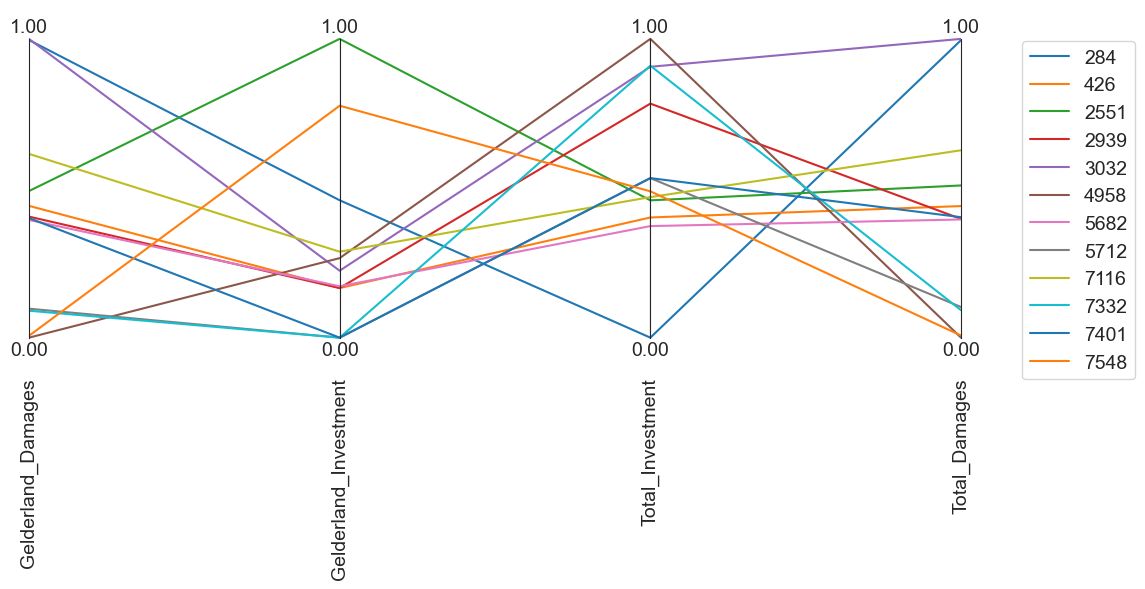

<Figure size 1000x600 with 0 Axes>

In [118]:

data = scores.loc[:, [
        
                        "Gelderland_Damages",
                        "Gelderland_Investment",
                        "Total_Investment",
                        "Total_Damages",
                        ]]
data = ((data-data.min())/(data.max()-data.min()))
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
paraxes = parcoords.ParallelAxes(limits)
for j, (ind, row) in enumerate(data.reset_index().iterrows()):
            paraxes.plot(row.to_frame().T, label=int(row['index']),
                          color=colors[j])
paraxes.legend()
#paraxes.plot(data)
plt.show()
#save plt with 300 dpi
plt.savefig('results/sns_gelderland_and_total.png', dpi=300)

        

##### 3c2 Calculate Regret

In [55]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [93]:
experiments, outcomes = rob_results
overall_regret = {}
max_regret = {}
df = pd.DataFrame(outcomes)
df["Gelderland_Deaths"] = df[[f"A.{i+1}_Expected Number of Deaths" for i in range(3)]].sum(axis=1)
df["Gelderland_Damages"] = df[[f"A.{i+1}_Expected Annual Damage" for i in range(3)]].sum(axis=1)
df["Gelderland_Investment"] = df[[f"A.{i+1}_Dike Investment Costs" for i in range(3)]].sum(axis=1)
df["Overijssel_Deaths"] = df[[f"A.{i}_Expected Number of Deaths" for i in [4, 5]]].sum(axis=1)
df["Overijssel_Damages"] = df[[f"A.{i}_Expected Annual Damage" for i in [4, 5]]].sum(axis=1)
df["Overijssel_Investment"] = df[[f"A.{i}_Dike Investment Costs" for i in [4, 5]]].sum(axis=1)
df["Total_Deaths"] = df["Gelderland_Deaths"] + df["Overijssel_Deaths"]
df["Total_Damages"] = df["Gelderland_Damages"] + df["Overijssel_Damages"]
df["Total_Investment"] = df["Gelderland_Investment"] + df["Overijssel_Investment"]
outcomes = df.to_dict('list')


for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevant information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # Convert your DataFrame to a numpy array before multi-dimensional indexing
    data_array = data.to_numpy()

    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = np.abs(data_array.max(axis=1)[:, np.newaxis] - data_array)
    # Convert numpy array back to DataFrame
    outcome_regret_df = pd.DataFrame(outcome_regret, index=data.index, columns=data.columns)
    
    overall_regret[outcome.name] = outcome_regret_df
    max_regret[outcome.name] = outcome_regret_df.max()



In [100]:
for name in ["Gelderland_Deaths", "Gelderland_Damages", "Gelderland_Investment","Overijssel_Deaths", "Overijssel_Damages", "Overijssel_Investment", "Total_Deaths", "Total_Damages", "Total_Investment"]:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevant information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({name: outcomes[name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # Convert your DataFrame to a numpy array before multi-dimensional indexing
    data_array = data.to_numpy()

    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = np.abs(data_array.max(axis=1)[:, np.newaxis] - data_array)
    # Convert numpy array back to DataFrame
    outcome_regret_df = pd.DataFrame(outcome_regret, index=data.index, columns=data.columns)
    
    overall_regret[name] = outcome_regret_df
    max_regret[name] = outcome_regret_df.max()

In [101]:
max_regret

,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Dike Investment Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Dike Investment Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Gelderland_Deaths,Gelderland_Damages,Gelderland_Investment,Overijssel_Deaths,Overijssel_Damages,Overijssel_Investment,Total_Deaths,Total_Damages,Total_Investment
policy,,,,,,,,,,,,,,,,,,,,,,,,,,
284,0.000000e+00,9.596605e+06,0.000000,4.001091e+08,1.659169e+07,0.230066,7.794614e+08,0.000000e+00,0.871239,5.870602e+07,5.254378e+06,0.018455,1.825663e+08,1.284033e+07,0.109092,527800000.0,1.630272e+07,0.805152,6.397239e+08,1.731400e+07,0.109154,1.827252e+08,1.284033e+07,0.805152,6.397239e+08,1.630272e+07
426,1.071653e+09,4.229151e+07,0.504992,3.856454e+08,1.156740e+07,0.218195,5.208118e+08,2.822764e+06,0.600163,5.748591e+07,5.254378e+06,0.017612,1.825663e+08,0.000000e+00,0.109092,310000000.0,3.395577e+07,0.583540,1.073507e+09,4.780738e+07,0.109154,1.827252e+08,0.000000e+00,0.583540,1.075534e+09,3.395577e+07
2551,1.177661e+09,5.036302e+06,0.520703,3.551351e+08,1.156740e+07,0.213371,7.740143e+08,0.000000e+00,0.862103,5.780951e+07,1.258646e+07,0.015211,4.866155e+07,1.284033e+07,0.051034,527800000.0,1.405021e+07,0.860206,1.177661e+09,7.729412e+06,0.046960,5.780951e+07,2.017241e+07,0.860206,1.151981e+09,1.405021e+07
2939,1.202881e+09,4.229151e+07,0.537839,3.137823e+08,1.156740e+07,0.204322,2.773011e+08,2.822764e+06,0.544396,7.110259e+07,0.000000e+00,0.019035,8.690893e+07,8.920489e+06,0.052045,473900000.0,3.762188e+07,0.537839,1.202881e+09,4.780738e+07,0.052108,8.706783e+07,3.666111e+06,0.537839,1.202881e+09,3.762188e+07
3032,0.000000e+00,9.596605e+06,0.000000,4.001091e+08,1.659169e+07,0.230066,5.271762e+08,2.822764e+06,0.665203,5.870274e+07,6.265658e+06,0.018439,1.825663e+08,8.920489e+06,0.109092,271700000.0,1.621692e+07,0.582044,3.874387e+08,2.013676e+07,0.109154,1.827252e+08,9.931769e+06,0.582044,3.874387e+08,1.621692e+07
4958,1.319039e+09,0.000000e+00,0.586323,3.678800e+08,6.051529e+06,0.208792,8.144581e+07,2.822764e+06,0.091019,2.812484e+07,6.265658e+06,0.009428,4.085646e+07,1.284033e+07,0.025164,217800000.0,0.000000e+00,0.710517,1.337753e+09,0.000000e+00,0.015398,2.812484e+07,1.385161e+07,0.710517,1.337753e+09,0.000000e+00
5682,1.202881e+09,4.229151e+07,0.537839,3.137823e+08,1.156740e+07,0.204322,4.905202e+08,0.000000e+00,0.592802,5.723179e+07,5.254378e+06,0.016811,4.510656e+07,1.284033e+07,0.046960,473900000.0,4.397334e+07,0.537839,1.202881e+09,4.498462e+07,0.046960,5.723179e+07,1.284033e+07,0.537839,1.202035e+09,4.397334e+07
5712,1.315111e+09,4.229151e+07,0.583349,2.828955e+08,1.659169e+07,0.156200,7.738867e+08,0.000000e+00,0.861824,3.362545e+07,6.265658e+06,0.009952,4.510656e+07,1.284033e+07,0.046960,225400000.0,5.000890e+07,0.868428,1.315111e+09,5.000890e+07,0.046960,4.510656e+07,1.385161e+07,0.868428,1.311093e+09,5.000890e+07
7116,1.177661e+09,5.036302e+06,0.520703,2.388175e+08,5.941010e+07,0.136264,5.208269e+08,2.822764e+06,0.664262,5.867314e+07,1.258646e+07,0.015211,9.746870e+07,1.284033e+07,0.058262,527800000.0,6.471568e+07,0.581103,1.177661e+09,5.839488e+07,0.058630,9.835467e+07,2.017241e+07,0.581103,1.151981e+09,6.471568e+07


visualize as heatmap

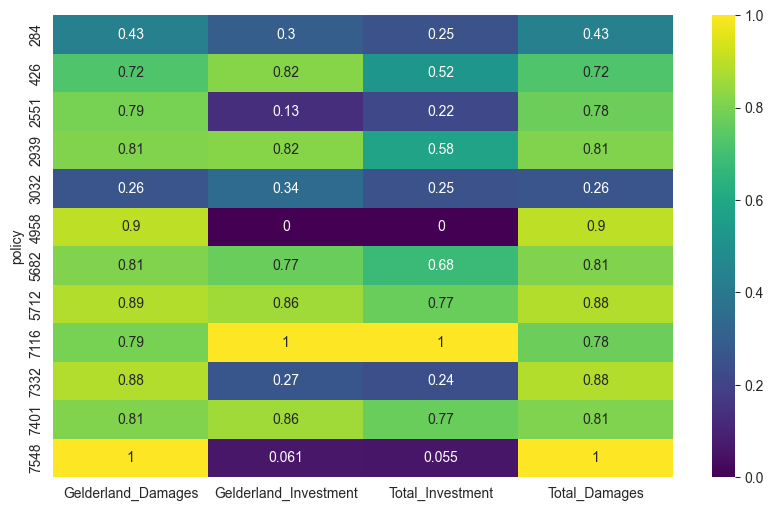

In [103]:
#only visualize Gelderland investment, damages and total investment and damages
max_regret_to_visualize = max_regret.loc[:, ["Gelderland_Damages", "Gelderland_Investment", "Total_Investment", "Total_Damages"]]


max_regret = pd.DataFrame(max_regret_to_visualize)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

visualize as parallel axis

/usr/local/lib/python3.11/site-packages/ema_workbench/analysis/parcoords.py:219: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)
/usr/local/lib/python3.11/site-packages/ema_workbench/analysis/parcoords.py:280: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


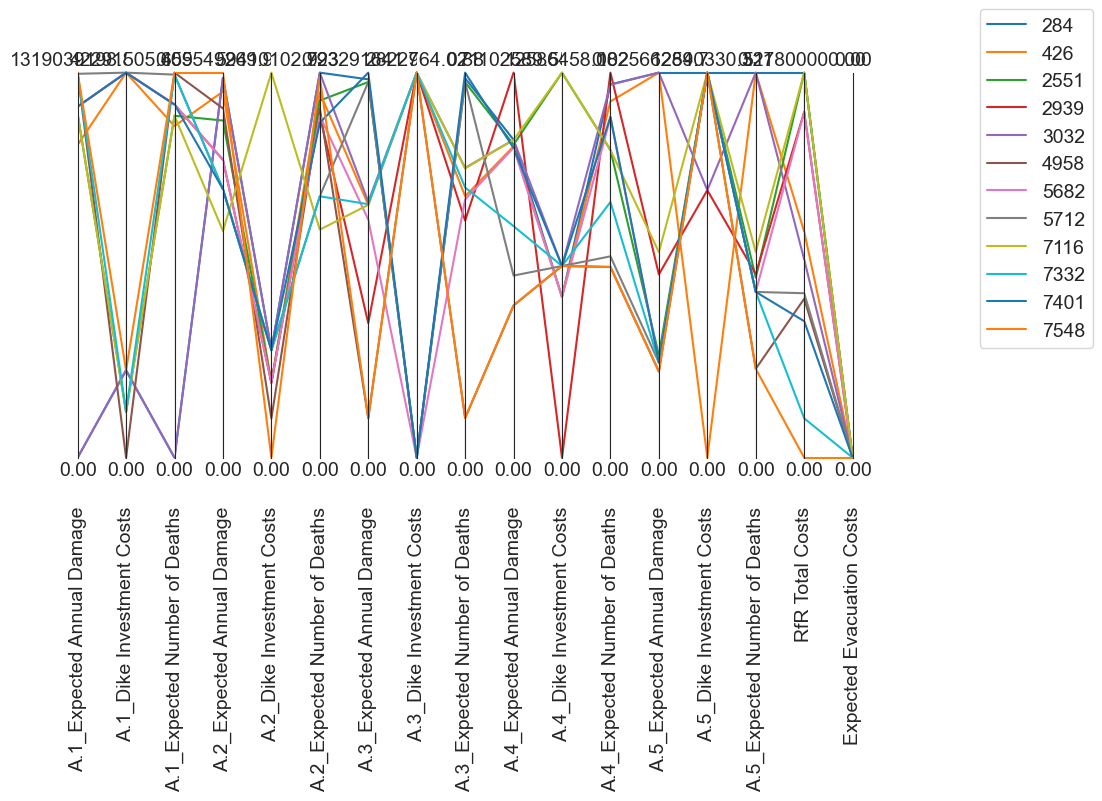

In [58]:
colors = sns.color_palette(n_colors=13)

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, :] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()